In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

## LOAD DATA

In [50]:
#load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/05.%20Week%205/Datasets/netflix_titles.csv'
df = pd.read_csv(url)

## INFO

In [51]:
# Tampilkan 5 data pertama
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [52]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,0
show_id,0
type,0
title,0
director,2634
cast,825
country,831
date_added,10
release_year,0
rating,4
duration,3


In [53]:
df.describe(include='all')

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,8807,8807,8807,6173,7982,7976,8797,8807.000000,8803,8804,8807,8807
unique,8807,2,8807,4528,7692,748,1767,NaN,17,220,514,8775
top,s8807,Movie,Zubaan,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",NaN,TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2818,109,NaN,3207,1793,362,4
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.180198,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.819312,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.000000,NaN,NaN,NaN,NaN


## FEATURE ENGINEERING

In [54]:
# --- Feature Engineering Ringan ---
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['main_genre'] = df['listed_in'].str.split(',').str[0]
df['num_cast'] = df['cast'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
df['main_country'] = df['country'].str.split(',').str[0]

In [55]:
# Pilih fitur yang ingin dikorelasikan
features = ['type', 'rating', 'main_genre', 'main_country', 'year_added', 'month_added', 'num_cast']

# Pisahkan fitur numerik & kategorikal
numerical_features = ['year_added', 'month_added', 'num_cast']
categorical_features = list(set(features) - set(numerical_features))

# Fungsi untuk hitung Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## EDA & VISUALISASI

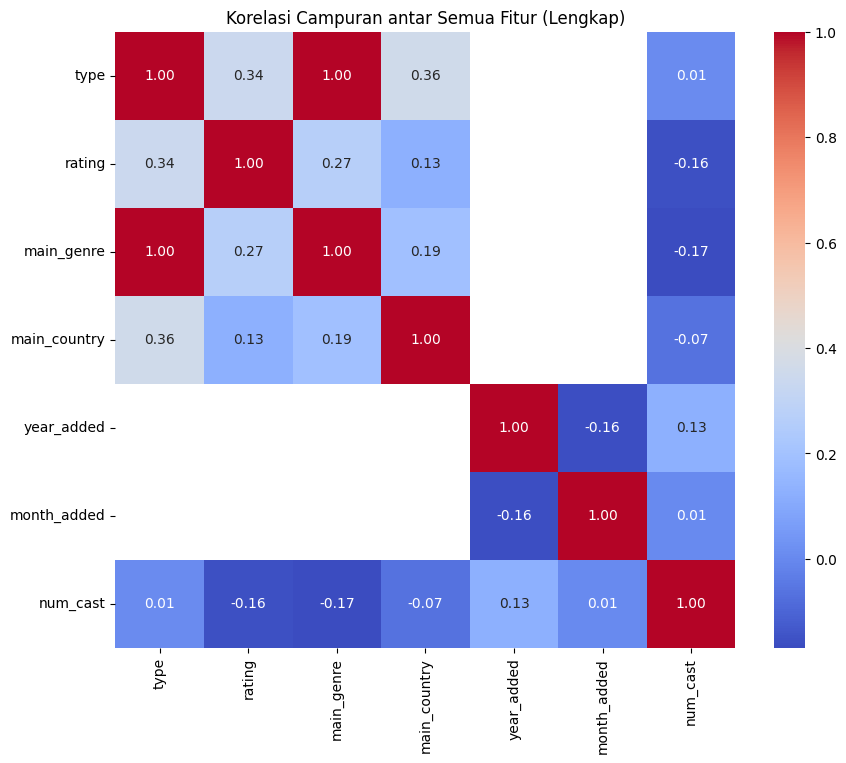

In [62]:
# Buat matriks korelasi campuran
corr_matrix = pd.DataFrame(index=features, columns=features)

for f1 in features:
    for f2 in features:
        try:
            if f1 == f2:
                value = 1.0
            elif f1 in categorical_features and f2 in categorical_features:
                value = cramers_v(df[f1], df[f2])
            elif f1 in numerical_features and f2 in numerical_features:
                value = df[[f1, f2]].corr().iloc[0, 1]
            else:
                le = LabelEncoder()
                if f1 in categorical_features:
                    x = le.fit_transform(df[f1].astype(str))
                    y = df[f2]
                else:
                    x = df[f1]
                    y = le.fit_transform(df[f2].astype(str))
                value = np.corrcoef(x, y)[0, 1]
        except:
            value = np.nan  # fallback jika error

        # Isi dua arah
        corr_matrix.loc[f1, f2] = value
        corr_matrix.loc[f2, f1] = value

# Konversi ke float & visualisasi ulang
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Campuran antar Semua Fitur (Lengkap)")
plt.show()

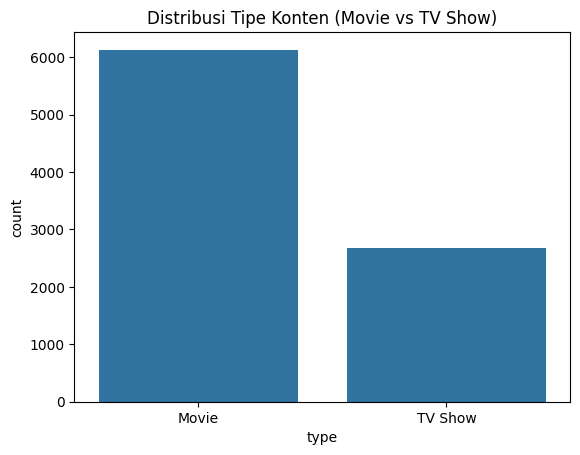

In [57]:
sns.countplot(data=df, x='type')
plt.title('Distribusi Tipe Konten (Movie vs TV Show)')
plt.show()

Berdasarkan grap di atas kita bisa melihat bahwa jumlah movie pada dataset lebih banyak dibandingkan dengan TV show.

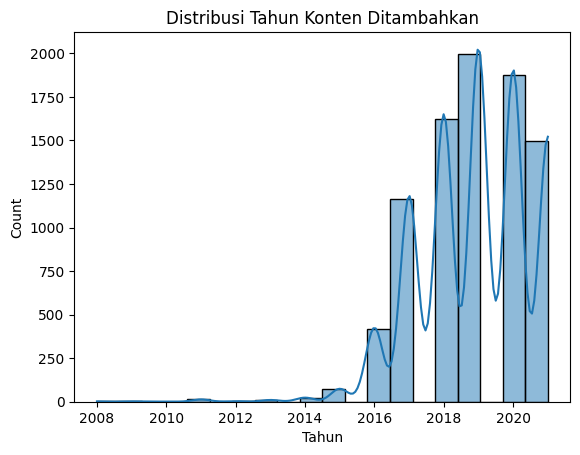

In [58]:
sns.histplot(df['year_added'].dropna(), bins=20, kde=True)
plt.title('Distribusi Tahun Konten Ditambahkan')
plt.xlabel('Tahun')
plt.show()


Berdasarkan graph diatas dapat dilihat bahwa penambahan film makin lama makin banyak hal ini membuktikan bahwa perkembangan film dari tahun ketahun mambaik namun diakhir diakhir graph sempat turun mungkin ini ada kaitannya dengan wabah covid19.

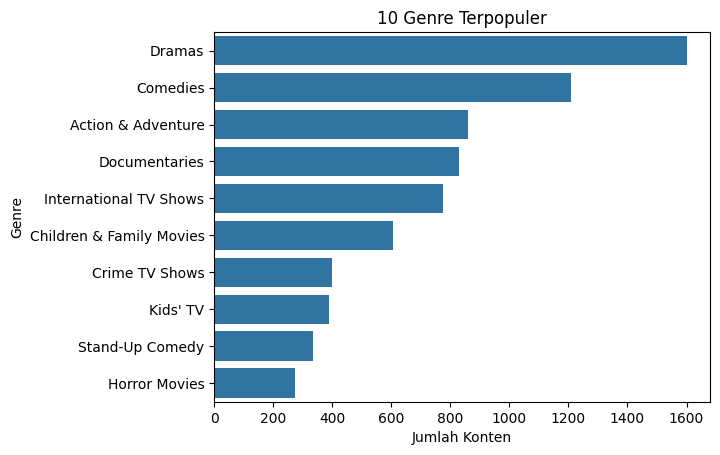

In [59]:
top_genres = df['main_genre'].value_counts().head(10)
sns.barplot(y=top_genres.index, x=top_genres.values)
plt.title('10 Genre Terpopuler')
plt.xlabel('Jumlah Konten')
plt.ylabel('Genre')
plt.show()


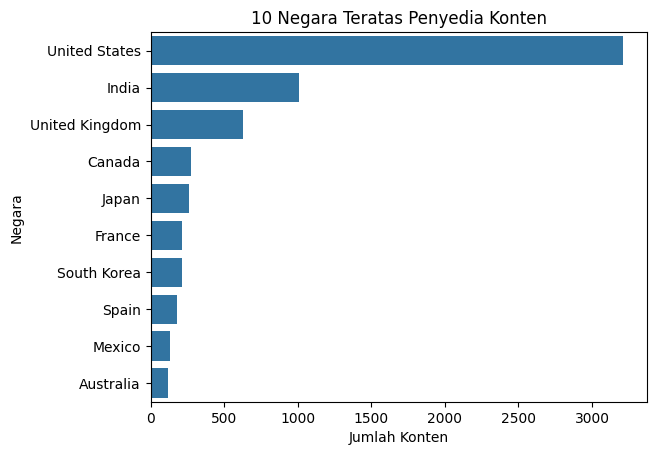

In [60]:
top_countries = df['main_country'].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title('10 Negara Teratas Penyedia Konten')
plt.xlabel('Jumlah Konten')
plt.ylabel('Negara')
plt.show()

## PENJELASAN MATEMATIKA

- Campuran (Kategorikal vs Numerik)
  - Proses yang dilakukan:
    - Label Encoding: ubah nilai kategorikal menjadi angka diskrit
    - Hitung pearson correlation dengan hasil encoding
  - Catatan penting:
    - Korelasi ini bisa menyesatkan karena skala angka dari encoding tidak mewakili urutan sebenarnya
    - Maka, hasilnya hanya indikasi kasar, bukan hubungan kausal
- Distribusi dan Visualisasi:
  - Membagi range data menjadi bin, lalu menghitung jumlah data dalam tiap bin
  - 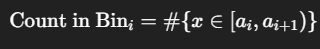
  - digunakan untuk:
    - Distribusi tahun penambahan (year_added)
    - Jumlah aktor (num_cast)